# Udacity Self-Driving Car Nanodegree
### Advanced Lane Finding Project

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
Determine the curvature of the lane and vehicle position with respect to center.
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Step 1: Camera Calibration

In [1]:
import pickle
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

CAL_IMG_PATH = './camera_cal/calibration*.jpg'
SAVE_PATH = './camera_calibrate_coefficients.p'

def calibrate_camera(save_file=False, NX=9, NY=6, cal_img_path=CAL_IMG_PATH, save_path=SAVE_PATH):
    """ 
    Create and save distortion coefficients for calibrating the camera
    Implementation models after the code from the Lesson 16 
    in section `Calibrating Your Camera` of Udacity's CarND 
    """
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image space

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ...
    objp = np.zeros((NY * NX, 3), np.float32)
    objp[:,:2] = np.mgrid[0:NX, 0:NY].T.reshape(-1,2)

    images = glob.glob(cal_img_path)

    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (NX, NY), None)
    
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Do camera calibration given object points and image points
    _, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

    if save_file:
        # Save the camera calibration
        print("Save result to File: ", save_path)
        result_pickle = {}
        result_pickle["mtx"] = mtx
        result_pickle["dist"] = dist
        pickle.dump(result_pickle, open(save_path, "wb" ))

    return mtx, dist

calibrate_camera(save_file=True)

Save result to File:  ./camera_calibrate_coefficients.p


(array([[  1.15396100e+03,   0.00000000e+00,   6.69706492e+02],
        [  0.00000000e+00,   1.14802503e+03,   3.85655582e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]),
 array([[ -2.41018767e-01,  -5.30665431e-02,  -1.15811319e-03,
          -1.28284935e-04,   2.67026162e-02]]))

### example of a distortion corrected calibration image

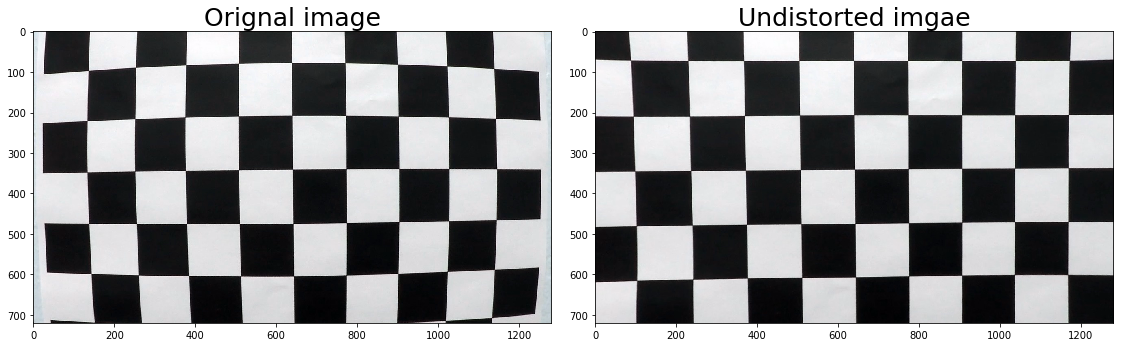

In [2]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

TEST_IMG_PATH = "./camera_cal/calibration1.jpg" 

dist_pickle = pickle.load(open("./camera_calibrate_coefficients.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

orig_img = cv2.imread(TEST_IMG_PATH)
undist_img = undistort(orig_img, mtx, dist)

## Drawing the compared pictures

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout()

ax1.imshow(orig_img, cmap='gray')
ax1.set_title("Orignal image" , fontsize=25)


ax2.imshow(undist_img, cmap='gray')
ax2.set_title("Undistorted imgae", fontsize=25)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### An example of a distorted image

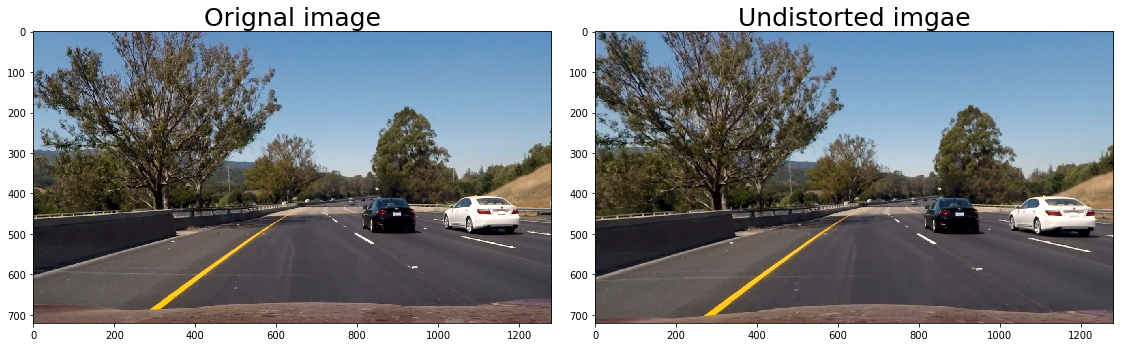

In [3]:
# Undistort road image
TEST_IMG_PATH = "./test_images/test6.jpg"

orig_img = cv2.imread(TEST_IMG_PATH)
# Convert to RGB space
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
undist_img = undistort(orig_img, mtx, dist)

## Drawing the compared pictures

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout()

ax1.imshow(orig_img, cmap='gray')
ax1.set_title("Orignal image" , fontsize=25)


ax2.imshow(undist_img, cmap='gray')
ax2.set_title("Undistorted imgae", fontsize=25)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step 2： Use color transforms, gradients, etc, to create a thresholded binary image

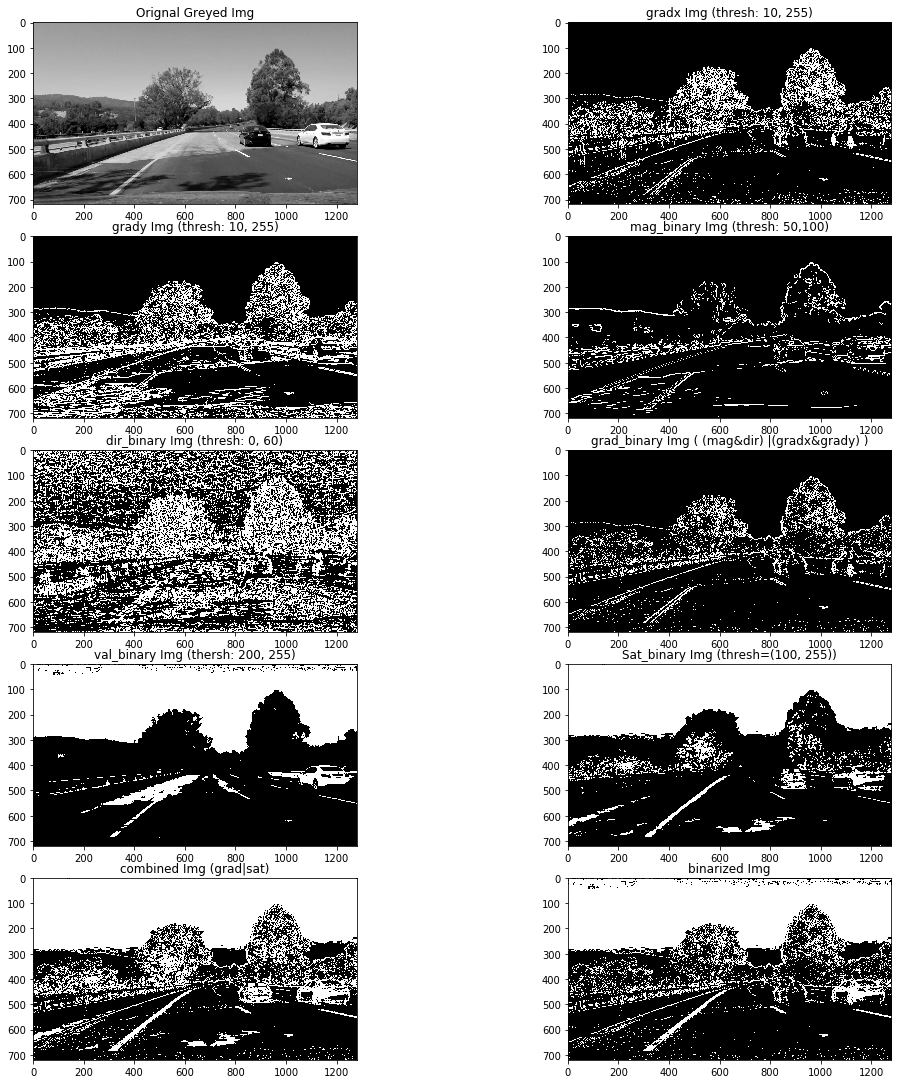

In [4]:
KERNEL = 17
GRAD_X_MAX = 255
GRAD_X_MIN = 10
GRAD_Y_MAX = 255
GRAD_Y_MIN = 10
MAG_MAX = 150
MAG_MIN = 50
DIR_MAX = np.pi/3
DIR_MIN = 0
S_MIN = 100
S_MAX = 255
V_MIN = 200
V_MAX = 255

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return mag_binary

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, int(orient == 'x'), int(orient != 'x'))
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))  
    grad_mask = np.zeros_like(scaled_sobel)
    grad_mask[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_mask

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    gradDirect = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    dir_mask = np.zeros_like(gradDirect)
    # 6) Return this mask as your binary_output image
    dir_mask[(thresh[0] < gradDirect) & (gradDirect < thresh[1])] = 1
    return dir_mask

# Thresholds the S-channel of HLS
def s_thresh(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_mask = np.zeros_like(s_channel)
    s_mask[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_mask

# Thresholds the V-channel of HSV
def v_thresh(img, thresh=(0, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_mask = np.zeros_like(v_channel)
    v_mask[(v_channel > thresh[0]) & (v_channel <= thresh[1])] = 1
    return v_mask

def binarize(image, kernel=KERNEL, x_thresh=(GRAD_X_MIN, GRAD_X_MAX),
             y_thresh=(GRAD_Y_MIN, GRAD_Y_MAX), magni_thresh=(MAG_MIN, MAG_MAX),
             dir_thresh=(DIR_MIN, DIR_MAX), sat_thresh=(S_MIN, S_MAX),
             val_thresh=(V_MIN, V_MAX)):
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=KERNEL, thresh=x_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=KERNEL, thresh=y_thresh)
    mag_binary = mag_thresh(image, sobel_kernel=KERNEL, thresh=magni_thresh)
    dir_binary = dir_threshold(image, sobel_kernel=KERNEL, thresh=dir_thresh)
    sat_binary = s_thresh(image, thresh=sat_thresh)
    val_binary = v_thresh(image, thresh=val_thresh)

    grad_binary = np.zeros_like(mag_binary)
    grad_binary[ ((gradx == 1) & (grady == 1)) | 
                 ((mag_binary == 1) & (dir_binary == 1))] = 1

    # Combining thresholds
    combined = np.zeros_like(mag_binary)
    combined[ (grad_binary == 1) | (sat_binary == 1) & (val_binary == 1) ] = 1
    #combined[ (sat_binary == 1) & (val_binary == 1) ] = 1

    # hightlight contributions from each channel
    channels = 255*np.dstack((grad_binary, sat_binary, val_binary)).astype('uint8')
    return combined, channels

TEST_IMG_PATH = "./test_images/test4.jpg"
orig_img = mpimg.imread(TEST_IMG_PATH)

binarized_img, channels_img = binarize(orig_img,  kernel=17,
                                  x_thresh=(10, 255), y_thresh=(10, 255), 
                                  magni_thresh=(50, 100), dir_thresh=(0, np.pi/3),
                                  sat_thresh=(100, 255), val_thresh=(200, 255))

# binarized_img, channels_img = binarize(orig_img,  kernel=17,
#                                  x_thresh=(10, 255), y_thresh=(10, 255), 
#                                  magni_thresh=(50, 100), dir_thresh=(0, np.pi/3),
#                                  sat_thresh=(100, 255), val_thresh=(200, 255))

## Drawing the compared pictures

#f, axes = plt.subplots(1, 2, figsize=(15, 5))
#f.tight_layout()

plot_img=[]
imgPathName=[]

gray = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
plot_img.append(gray)
imgPathName.append("Orignal Greyed Img")

gradx = abs_sobel_thresh(orig_img, orient='x', sobel_kernel=17, thresh=(10,255))
plot_img.append(gradx)
imgPathName.append("gradx Img (thresh: 10, 255)")

grady = abs_sobel_thresh(orig_img, orient='y', sobel_kernel=17, thresh=(10,255))
plot_img.append(grady)
imgPathName.append("grady Img (thresh: 10, 255)")

mag_binary = mag_thresh(orig_img, sobel_kernel=17, thresh=(50,100))
plot_img.append(mag_binary)
imgPathName.append("mag_binary Img (thresh: 50,100)")

dir_binary = dir_threshold(orig_img, sobel_kernel=17, thresh=(0, np.pi/3))
plot_img.append(dir_binary)
imgPathName.append("dir_binary Img (thresh: 0, 60)")

grad_binary = np.zeros_like(gray)

grad_binary[ (((mag_binary == 1) & (dir_binary == 1))) | ((gradx == 1) & (grady == 1)) ] =1 
plot_img.append(grad_binary)
imgPathName.append("grad_binary Img ( (mag&dir) |(gradx&grady) )")

#grad_binary[ ((gradx == 1) & (grady == 1))] =1 

#| 
#                 ((mag_binary == 1) & (dir_binary == 1))] = 1

val_binary = v_thresh(orig_img, thresh=(200,255))
plot_img.append(val_binary)
imgPathName.append("val_binary Img (thersh: 200, 255)")

sat_binary = s_thresh(orig_img, thresh=(100,255))
plot_img.append(sat_binary)
imgPathName.append("Sat_binary Img (thresh=(100, 255))")

combined = np.zeros_like(mag_binary)
combined[ (grad_binary == 1) | (sat_binary==1)] =1 
plot_img.append(combined)
imgPathName.append("combined Img (grad|sat)")

plot_img.append(binarized_img)
imgPathName.append("binarized Img")

#combined[ (grad_binary == 1) | (sat_binary == 1) & (val_binary == 1) ] = 1
#| 
#                 ((mag_binary == 1) & (dir_binary == 1))] = 1

#ax1.imshow(sat_binary, cmap='gray')
#ax1.imshow(val_binary, cmap='gray')
#ax1.imshow(grad_binary, cmap='gray')
#ax1.imshow(orig_img, cmap='gray')
#ax1.set_title("Orignal image" , fontsize=25)


#ax2.imshow(binarized_img, cmap='gray')
#ax2.set_title("Binarized image", fontsize=25)

f, axes = plt.subplots(5, 2, figsize=(15, 15))
indexes=range(5*2)
f.tight_layout()
imgLength=len(plot_img)

for ax, index in zip(axes.flat, indexes):
    if index < imgLength:
        
        ax.set_title(imgPathName[index])
        ax.imshow(plot_img[index], cmap='gray')

#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

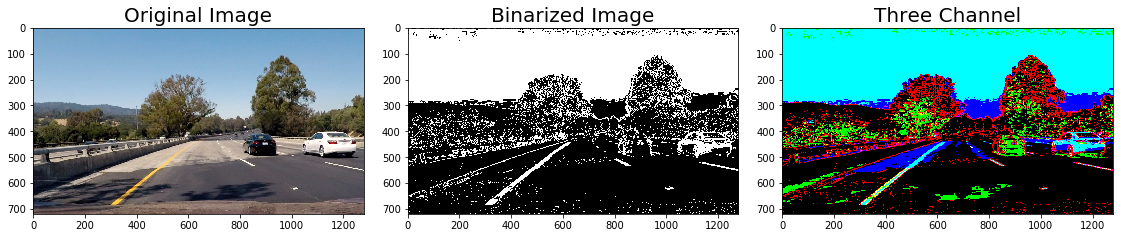

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
f.tight_layout()
ax1.imshow(orig_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(binarized_img, cmap='gray')
ax2.set_title('Binarized Image', fontsize=20)
ax3.imshow(channels_img)
ax3.set_title('Three Channel', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Step 3: Apply a perspective transform to rectify binary image

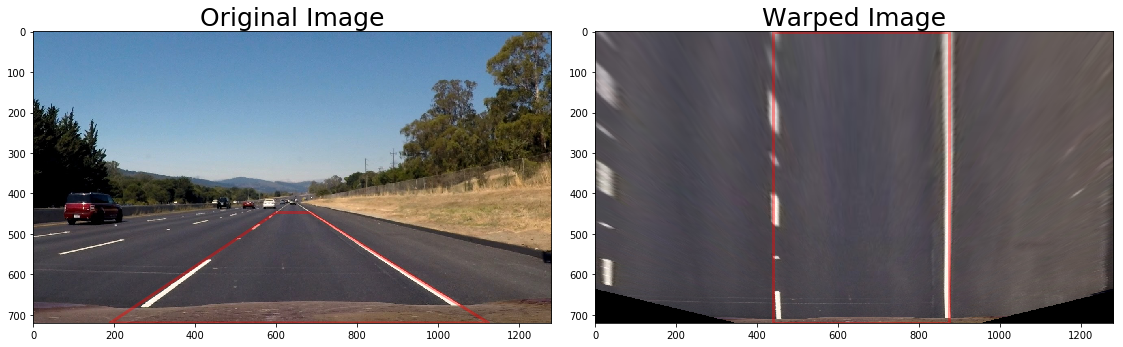

In [6]:
OFFSET = 250
# Corner coordinates picked from "./test_images/straigt_lines1.jpg"
CORNERS = np.float32([[190,720],[600,447],[685,447],[1125,720]])

def bird_eye_view_old(img, offset=OFFSET, corners=CORNERS):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(corners)
    # from Bot-left, clockwise
    dst = np.float32([[corners[0][0] + offset, corners[0][1]],
                      [corners[0][0] + offset, 0],
                      [corners[3][0] - offset, 0],
                      [corners[3][0] - offset, corners[3][1]]])   
                      
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M, Minv

def bird_eye_view(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
                      
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)   
    
    return warped, M, Minv

TEST_IMG_PATH = "./test_images/straight_lines2.jpg"
orig_img = mpimg.imread(TEST_IMG_PATH)

offset = 250
corners = np.float32([[190,720],[600,447],[685,447],[1125,720]])
src = corners

dst = np.float32([[corners[0][0] + offset, corners[0][1]],
                      [corners[0][0] + offset, 0],
                      [corners[3][0] - offset, 0],
                      [corners[3][0] - offset, corners[3][1]]])   

# warped_img, _, _ = bird_eye_view(orig_img)
warped_img, _, _ = bird_eye_view(orig_img, src, dst)

#                               , offset, corners)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f.tight_layout()
x = [corners[0][0],corners[1][0],corners[2][0],corners[3][0],corners[0][0]]
y = [corners[0][1],corners[1][1],corners[2][1],corners[3][1],corners[0][1]]
ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.imshow(orig_img)
ax1.set_title('Original Image', fontsize=25)
x = [dst[0][0],dst[1][0],dst[2][0],dst[3][0],dst[0][0]]
y = [dst[0][1],dst[1][1],dst[2][1],dst[3][1],dst[0][1]]
ax2.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax2.imshow(warped_img)
ax2.set_title('Warped Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Define Image Process Pipeline

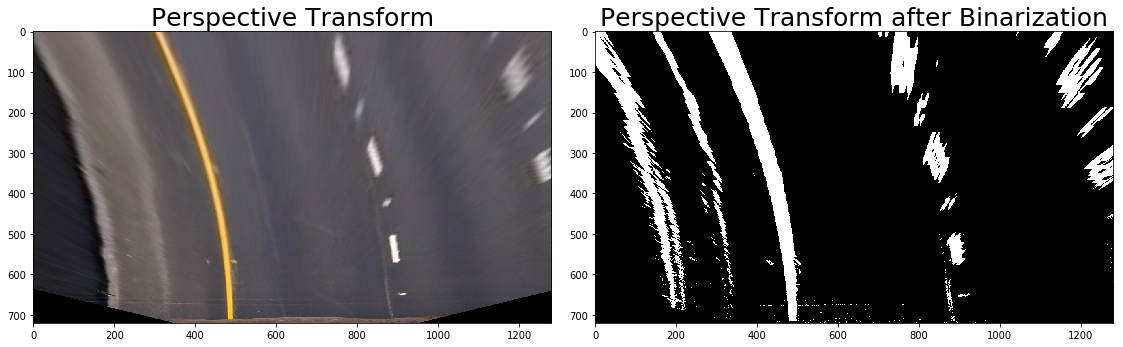

In [7]:
def pipeline(img_path):

    img = mpimg.imread(img_path)
    img = undistort(img, mtx, dist)
    binary, _ = binarize(img)
    bird_eye, _, Minv = bird_eye_view(binary, src, dst)
    return bird_eye, Minv

def compare_img(orig, new, orig_title, new_title, orig_gray=False, new_gray=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    f.tight_layout()
    if orig_gray:
        ax1.imshow(orig, cmap='gray')
    else:
        ax1.imshow(orig)
    ax1.set_title(orig_title, fontsize=25)
    if new_gray:
        ax2.imshow(new, cmap='gray')
    else:
        ax2.imshow(new)
    ax2.set_title(new_title, fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
TEST_IMG_PATH = "./test_images/test2.jpg"
orig_img = mpimg.imread(TEST_IMG_PATH)
bird_eye, _, _ = bird_eye_view(orig_img, src, dst)
filtered_bird_eye, Minv = pipeline(TEST_IMG_PATH)
compare_img(bird_eye, filtered_bird_eye, 'Perspective Transform', 'Perspective Transform after Binarization', new_gray=True)

### Step 4: Detect lane pixels and fit to find the lane boundary

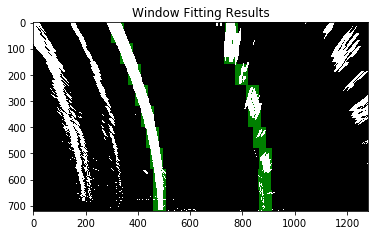

In [8]:
# Code source from Udacity Lesson "Advance Techniques for Lane Finding"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = filtered_bird_eye
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('Window Fitting Results')
plt.savefig('./img/conv_win.jpg')
plt.show()

490.045748718 897.387428068


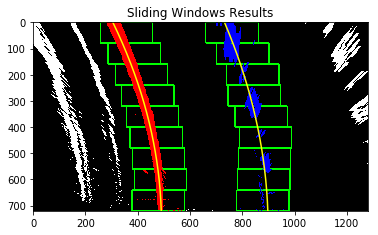

(0, 1280)

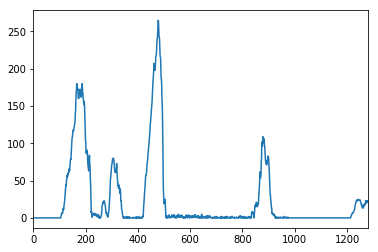

In [9]:
# Code source from Udacity Lesson "Advance Techniques for Lane Finding"

TEST_IMG_PATH = "./test_images/test2.jpg"
filtered_bird_eye, Minv = pipeline(TEST_IMG_PATH)
warped = filtered_bird_eye

# Assuming you have created a warped binary image called "warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
quarter_point = np.int(midpoint//2)
# Previously the left/right base was the max of the left/right half of the histogram
# this changes it so that only a quarter of the histogram (directly to the left/right) is considered
leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 3) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 


# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Visualization
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

print(left_fitx[-1], right_fitx[-1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title("Sliding Windows Results")
plt.savefig('./img/slide_win.jpg')
plt.show()

plt.plot(histogram)
plt.xlim(0, 1280)

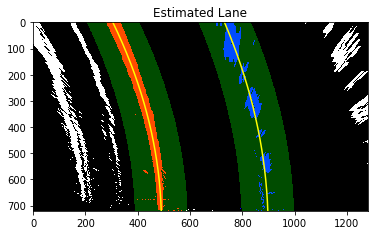

In [10]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title("Estimated Lane")
plt.savefig('./img/lane_drawn.jpg')
plt.show()

### Step 5： Calculate Distance from Center of lane and Curvature

In [11]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Calculate Distance from center of the lane
car_position = warped.shape[1] / 2
h = warped.shape[0]
lane_center = (left_fitx + right_fitx) / 2
lane_offset = (car_position - lane_center[-1]) * xm_per_pix
print("Distance from Center of Lane {:.3f} m".format(lane_offset))

Distance from Center of Lane -0.284 m


In [12]:
# Define y-value where we want radius of curvature# Define 
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print("Left Lane Curvature: {:.3f} pixels, Right Lane Curvature: {:.3f} pixels".format(left_curverad, right_curverad))
# Example values: 1926.74 1908.48

Left Lane Curvature: 1595.991 pixels, Right Lane Curvature: 1855.085 pixels


In [13]:
y_eval = np.max(ploty)

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print("Left Lane Curvature: {:.3f} m, Right Lane Curvature: {:.3f} m".format(left_curverad, right_curverad))
# Example values: 632.1 m    626.2 m


Left Lane Curvature: 523.445 m, Right Lane Curvature: 608.160 m


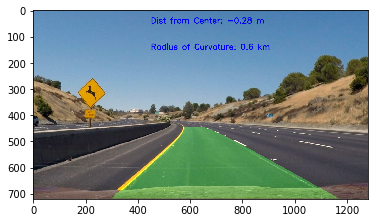

In [14]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

orig_img = mpimg.imread(TEST_IMG_PATH)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (orig_img.shape[1], orig_img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(orig_img, 1, newwarp, 0.3, 0)

font = cv2.FONT_HERSHEY_SIMPLEX
curvature = 0.5*(left_curverad + right_curverad)/1000
reportTxt1 = "Dist from Center: {:.2f} m".format(lane_offset)
reportTxt2 = "Radius of Curvature: {:.1f} km".format(curvature)

cv2.putText(result, reportTxt1, (450,50), font, 1, (0,0,255), 2, cv2.LINE_AA)
cv2.putText(result, reportTxt2, (450,150), font, 1, (0,0,255), 2, cv2.LINE_AA) 

plt.imshow(result)

### Step 6: Testing my Pipeline

In [15]:
MARGIN = 100
N_WINDOWS = 9
MIN_PIXEL = 50

XM_PER_PIX = 3.7/700 # meters per pixel in y dimension
YM_PER_PIX = 30/720 # meters per pixel in x dimension

def sliding_win_fit(warped, nwindows=N_WINDOWS, margin=MARGIN,
                     minpix=MIN_PIXEL, line=None):
    """ Given a bird-eye view of the road, polynomials fits the 
    left and right lanes, and return these two polynomial fits
    
    Arguments:
        warped {np.array} -- a binarized image after perspective
            transform.
    
    Keyword Arguments:
        nwindows {int} -- number of sliding windows 
            (default: {9})
        margin {int} -- width of the windows +/- margin 
            (default: {100})
        minpix {int} -- minimum number of pixels found to recenter window 
            (default: {50})
    Return:
        left_fit {array} -- coefficients for a 2nd degree polynomial fit
        right_fit {array} -- coefficients for a 2nd degree polynomial fit
        out_img {np.array} -- image with windows drawn
    """
    # Set height of windows
    window_height = np.int(warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped, warped, warped))*255

    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    # Ignore the leftmost and rightmost quarter of the image
    # to reduce noise
    # TODO: Maybe there is a more robust method to replace this.
    quarter_point = np.int(midpoint//2)
    # Only the quarter directly to the left/right of the midpoint is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), 
            (win_xleft_high,win_y_high), (0,255,0), 3) 
        cv2.rectangle(out_img, (win_xright_low,win_y_low), 
            (win_xright_high,win_y_high), (0,255,0), 3) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & 
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & 
                           (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & 
                           (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, out_img


def get_dist_from_center(warped, left_fit, right_fit, xm_per_pix=XM_PER_PIX):
    """Calculate the distance from the center of the lane
    
    Arguments:
        warped {np.array} -- a binarized image after perspective
            transform.
        left_fit {array} -- coefficients for a 2nd degree polynomial fit
        right_fit {array} -- coefficients for a 2nd degree polynomial fit
    
    Keyword Arguments:
        xm_per_pix {float} -- pixel to meter ratio (default: {3.7/700})
    
    Returns:
        [float] -- distance away from the center of the lane in UNIT METERS.
    """
    # The bottom-most of the image
    max_y = warped.shape[0]-1
    # Calculate Distance from center of the lane
    car_position = warped.shape[1] / 2
    center_fit = (left_fit + right_fit) / 2
    # lane_center = (left_fitx + right_fitx) / 2
    lane_offset = center_fit[0] * max_y ** 2 + center_fit[1] * max_y + center_fit[2]
    dist = (car_position - lane_offset) * xm_per_pix
    # print("Distance from Center of Lane {:.3f} m".format(dist)) 
    return dist

def get_curvature(warped, left_fit, right_fit, 
                    xm_per_pix=XM_PER_PIX, ym_per_pix=YM_PER_PIX):
    # Define y-value where we want radius of curvature
    y_eval = warped.shape[0]-1
    # New polynomial coefficients after scaling
    # BEFORE: x =        a*(y**2)         +     b*y     + c
    # AFTER:  x = mx/(my ** 2)*a*(y ** 2) + (mx/my)*b*y + c
    left_fit_cr = [xm_per_pix / (ym_per_pix ** 2) * left_fit[0],
                   (xm_per_pix / ym_per_pix) * left_fit[1],
                   left_fit[2]]
    right_fit_cr = [xm_per_pix / (ym_per_pix ** 2) * right_fit[0],
                   (xm_per_pix / ym_per_pix) * right_fit[1],
                   right_fit[2]]
    # Calculate the new radii of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print("Left Lane Curvature: {:.3f} m, Right Lane Curvature: {:.3f} m".format(left_curverad, right_curverad))
    return left_curverad, right_curverad

def draw_lane(orig, warped, Minv, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (orig.shape[1], orig.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig, 1, newwarp, 0.3, 0)

    return result

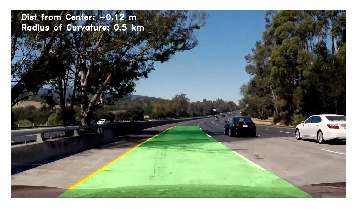

In [16]:
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# from line import Line
from cv2 import putText, FONT_HERSHEY_DUPLEX
# from advLaneFind import find_lane


COEF_PATH = "./camera_calibrate_coefficients.p"
dist_pickle = pickle.load(open(COEF_PATH, "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def write_info_on_img(img, left_curv, right_curv, dist_from_center):
    font = cv2.FONT_HERSHEY_DUPLEX
    curvature = 0.5 * (left_curv + right_curv) / 1000
    reportTxt1 = "Dist from Center: {:.2f} m".format(dist_from_center)
    reportTxt2 = "Radius of Curvature: {:.1f} km".format(curvature)
    cv2.putText(img, reportTxt1, (40,40), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(img, reportTxt2, (40,80), font, 1, (255,255,255), 2, cv2.LINE_AA) 
    return img

def find_lane(img, mtx, dist, line):
    undist = undistort(img, mtx, dist)
    binary, _ = binarize(undist)
    warped, _, Minv = bird_eye_view(binary, src, dst)
    left_fit, right_fit, _ = sliding_win_fit(warped)
    result = draw_lane(img, warped, Minv, left_fit, right_fit)
    dist_from_center = get_dist_from_center(warped, left_fit, right_fit)
    left_curv, right_curv = get_curvature(warped, left_fit, right_fit)
   
    return write_info_on_img(result, left_curv, right_curv, dist_from_center)

img = mpimg.imread("./test_images/test5.jpg")

result = find_lane(img, mtx, dist, None)
fig = plt.imshow(result)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.axis('off')
plt.savefig('./img/result5.png', bbox_inches='tight', pad_inches = 0)

In [17]:
import pickle
from moviepy.editor import VideoFileClip


COEF_PATH = "./camera_calibrate_coefficients.p"
dist_pickle = pickle.load(open(COEF_PATH, "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def process_img(img):
    return find_lane(img, mtx, dist, None)

In [18]:
video_out = 'project_video_output_bk.mp4'
video_in = VideoFileClip('./project_video.mp4')
processed_video = video_in.fl_image(process_img)
%time processed_video.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video project_video_output_bk.mp4
[MoviePy] Writing video project_video_output_bk.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:00<00:00,  3.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_bk.mp4 

Wall time: 6min 1s
